<h1>DUNEX Data Exploration Notebook </h1>
Written By: EJ Rainville, Fall 2021

In [4]:
# Import Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from scipy import signal
from scipy import fft
%matplotlib widget

<h2>Analysis of Mission 0</h2>

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: microSWIFT_25, microSWIFT_41, microSWIFT_31, microSWIFT_21, microSWIFT_11, microSWIFT_32
['microSWIFT_25', 'microSWIFT_41', 'microSWIFT_31', 'microSWIFT_21', 'microSWIFT_11', 'microSWIFT_32']


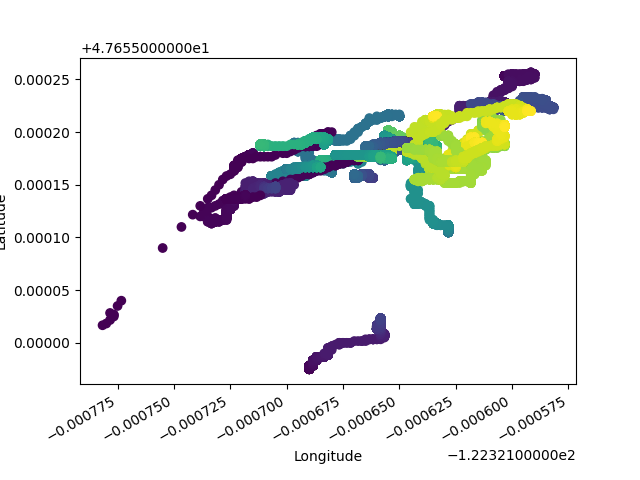

In [23]:
# Import data from mission netCDF
nc_file_name = '../microSWIFT_data/mission_0/mission_0.nc'
mission_0_dataset = nc.Dataset(nc_file_name, mode='r')
print(mission_0_dataset)
microSWIFTs_on_mission = list(mission_0_dataset.groups.keys())
print(microSWIFTs_on_mission)

# Create figure 
fig, ax = plt.subplots()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.autofmt_xdate()
for microSWIFT in microSWIFTs_on_mission:
    ax.scatter(mission_0_dataset[microSWIFT]['GPS']['lon'][:], mission_0_dataset[microSWIFT]['GPS']['lat'][:], c=mission_0_dataset[microSWIFT]['GPS']['time'][:])